In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'IFF'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../csv_files/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2009-03-31,560,-338,222,47,88,418,452,1051,666,...,2620,95,0,90,346,1125,1982,-14,-8,79.1
1,2009-06-30,568,-340,228,48,164,472,441,1187,666,...,2776,118,0,73,408,1141,2063,102,-11,79.1
2,2009-09-30,613,-364,249,53,155,477,436,1192,666,...,2791,141,0,2,358,1156,2035,113,-11,79.1
3,2009-12-31,586,-350,235,47,80,444,445,1128,666,...,2645,161,0,77,485,935,1876,92,-37,79.1
4,2010-03-31,654,-384,270,64,90,469,447,1172,666,...,2678,154,0,81,475,934,1865,32,-13,80.4


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
55,2022-12-31,2023-02-11,255.0,2844,-1975,869,-24,483,1818,3151,...,9082,35504,1418,193,404,3472,10373,17849,208,-160
56,2023-03-31,2023-04-21,255.0,3027,-2063,964,-8,590,1899,2946,...,8968,35470,1197,589,1482,4585,9220,17712,127,-175
57,2023-06-30,2023-07-21,255.0,2929,-1996,933,27,638,1887,2790,...,8813,34459,1227,159,1203,3630,9208,16836,248,-115
58,2023-09-30,2023-10-21,255.0,2820,-1896,924,27,629,1831,2549,...,8381,33395,1112,0,1142,3420,9159,16417,420,-100
59,2023-12-31,2024-02-11,255.0,2703,-1843,860,-2609,709,1726,2477,...,18992,30978,0,0,885,3758,9186,16336,644,-113


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
55,2022-12-31,2023-02-11,255.0,2844,-1975,869,-24,483,1818,3151,...,35504,1418,193,404,3472,10373,17849,208,-160,1
56,2023-03-31,2023-04-21,255.0,3027,-2063,964,-8,590,1899,2946,...,35470,1197,589,1482,4585,9220,17712,127,-175,1
57,2023-06-30,2023-07-21,255.0,2929,-1996,933,27,638,1887,2790,...,34459,1227,159,1203,3630,9208,16836,248,-115,1
58,2023-09-30,2023-10-21,255.0,2820,-1896,924,27,629,1831,2549,...,33395,1112,0,1142,3420,9159,16417,420,-100,1
59,2023-12-31,2024-02-11,255.0,2703,-1843,860,-2609,709,1726,2477,...,30978,0,0,885,3758,9186,16336,644,-113,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
55,2022-12-31,2023-02-11,255.0,2844.0,-1975.0,869.0,-24.0,483.0,1818.0,3151.0,...,35504.0,1418.0,193.0,404.0,3472.0,10373.0,17849.0,208.0,-160.0,1
56,2023-03-31,2023-04-21,255.0,3027.0,-2063.0,964.0,-8.0,590.0,1899.0,2946.0,...,35470.0,1197.0,589.0,1482.0,4585.0,9220.0,17712.0,127.0,-175.0,1
57,2023-06-30,2023-07-21,255.0,2929.0,-1996.0,933.0,27.0,638.0,1887.0,2790.0,...,34459.0,1227.0,159.0,1203.0,3630.0,9208.0,16836.0,248.0,-115.0,1
58,2023-09-30,2023-10-21,255.0,2820.0,-1896.0,924.0,27.0,629.0,1831.0,2549.0,...,33395.0,1112.0,0.0,1142.0,3420.0,9159.0,16417.0,420.0,-100.0,1
59,2023-12-31,2024-02-11,255.0,2703.0,-1843.0,860.0,-2609.0,709.0,1726.0,2477.0,...,30978.0,0.0,0.0,885.0,3758.0,9186.0,16336.0,644.0,-113.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2009-04-27,21.244354,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,0.243511,0.756489,5.358852,14.231579,25.454545,2.99115,0.396429,0.083929,0.071756,0.294671
1,2009-05-04,22.048847,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,0.243511,0.756489,5.358852,14.231579,25.454545,2.99115,0.396429,0.083929,0.071756,0.294671
2,2009-05-11,21.358259,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,0.243511,0.756489,5.358852,14.231579,25.454545,2.99115,0.396429,0.083929,0.071756,0.294671
3,2009-05-18,21.821026,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,0.243511,0.756489,5.358852,14.231579,25.454545,2.99115,0.396429,0.083929,0.071756,0.294671
4,2009-05-25,22.710957,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,0.243511,0.756489,5.358852,14.231579,25.454545,2.99115,0.396429,0.083929,0.071756,0.294671


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2009-04-27,21.244354,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,2.99115,0.396429,0.083929,0.071756,0.294671,8.938449,2.633900,0.750191,1.595727,-70.017851
1,2009-05-04,22.048847,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,2.99115,0.396429,0.083929,0.071756,0.294671,9.276935,2.733642,0.778600,1.624136,-72.669326
2,2009-05-11,21.358259,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,2.99115,0.396429,0.083929,0.071756,0.294671,8.986374,2.648022,0.754214,1.599749,-70.393263
3,2009-05-18,21.821026,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,2.99115,0.396429,0.083929,0.071756,0.294671,9.181081,2.705397,0.770555,1.616091,-71.918464
4,2009-05-25,22.710957,2009-03-31,560.0,2.376738,8.06574,79.1,-24.0,-0.303413,88.0,...,2.99115,0.396429,0.083929,0.071756,0.294671,9.555514,2.815731,0.801981,1.647516,-74.851528


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

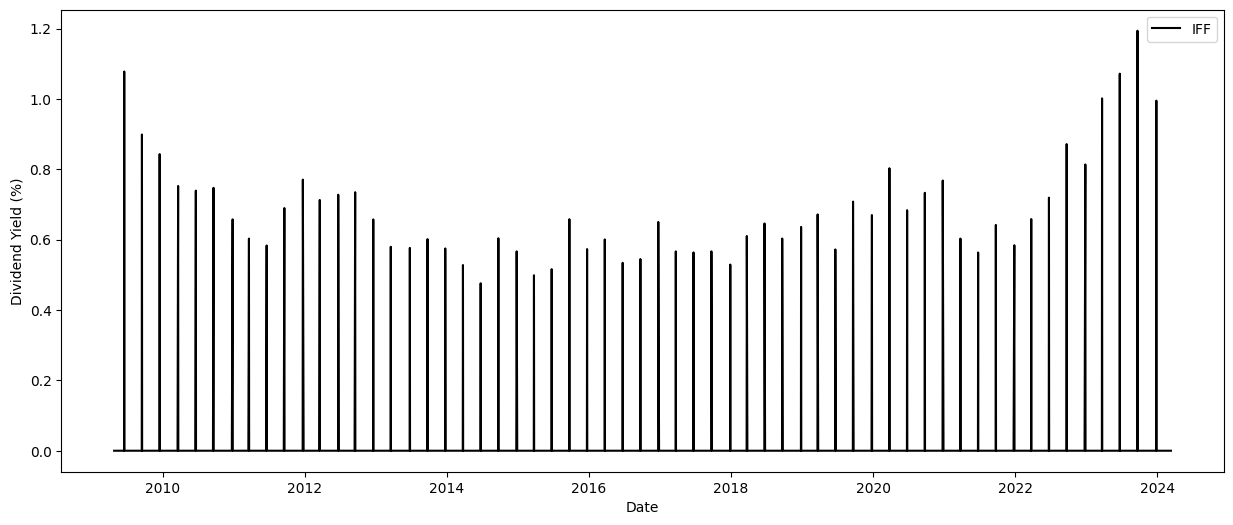

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


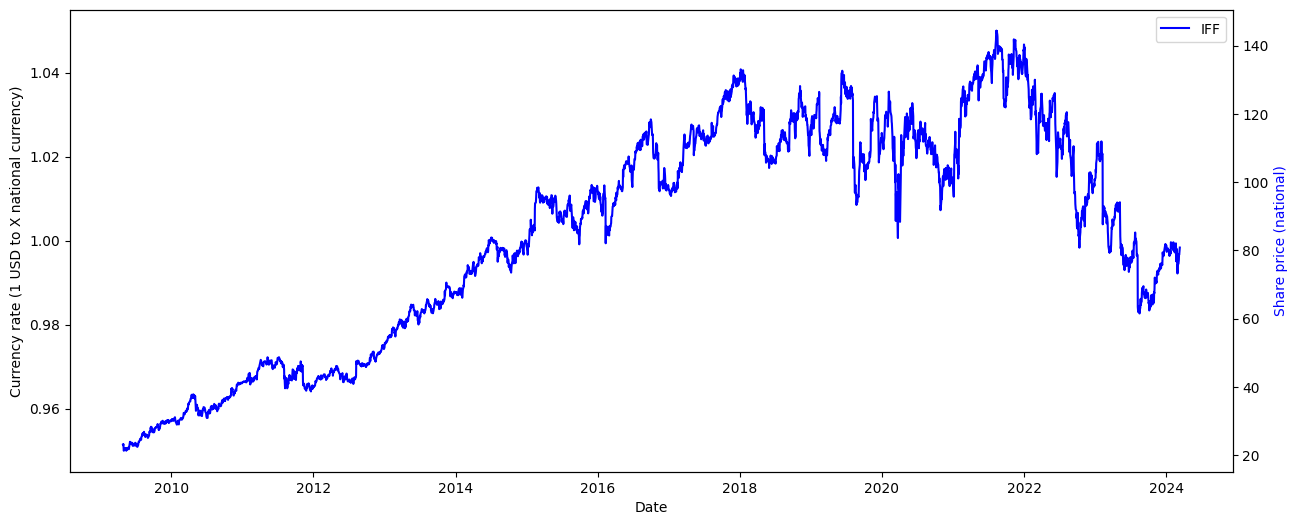

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

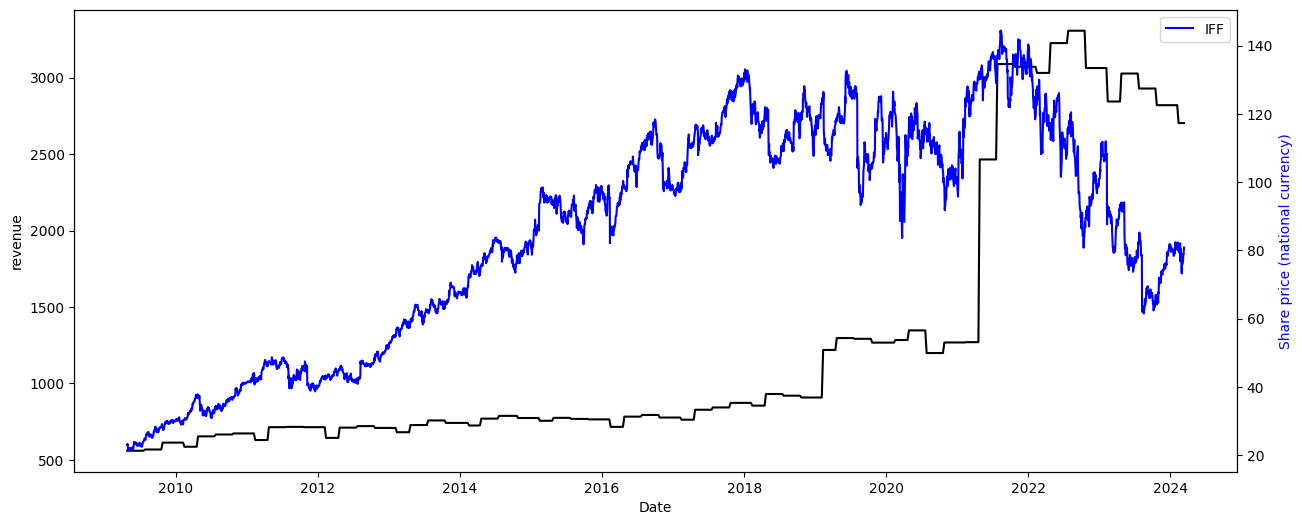

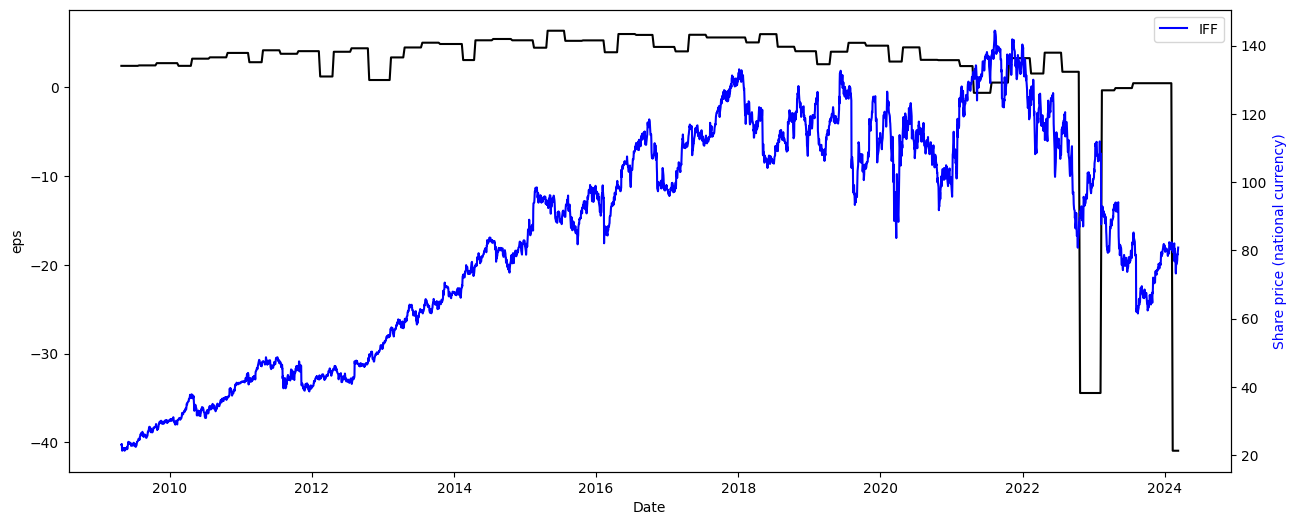

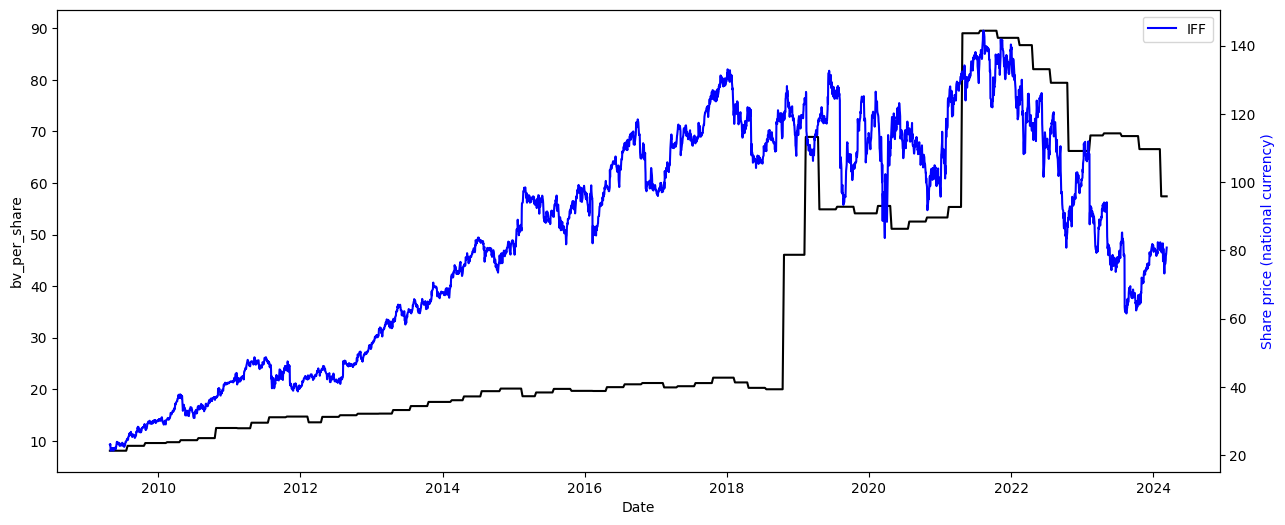

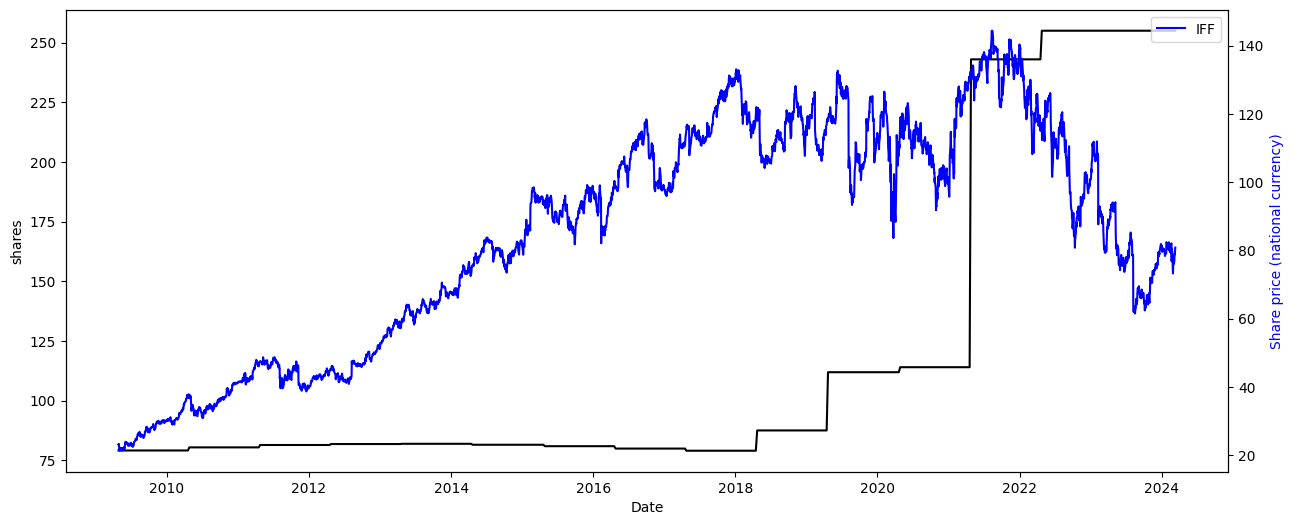

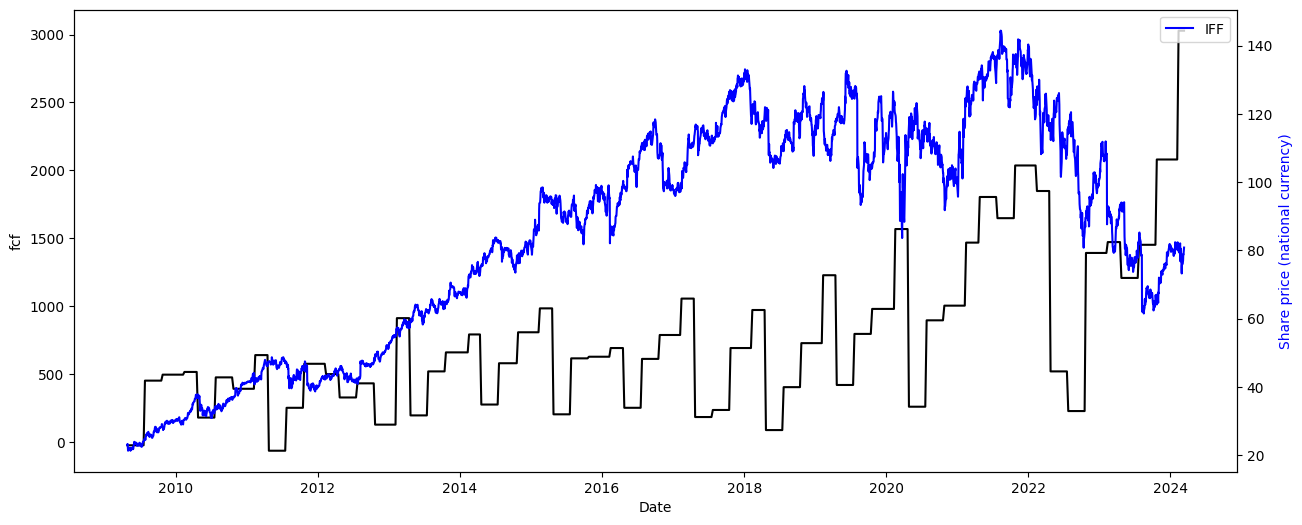

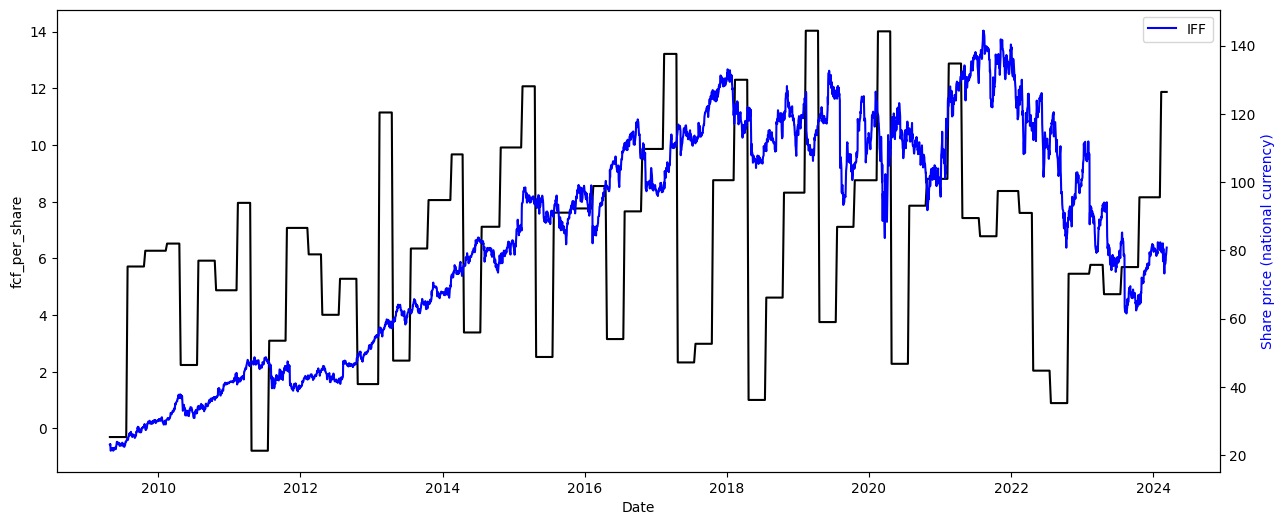

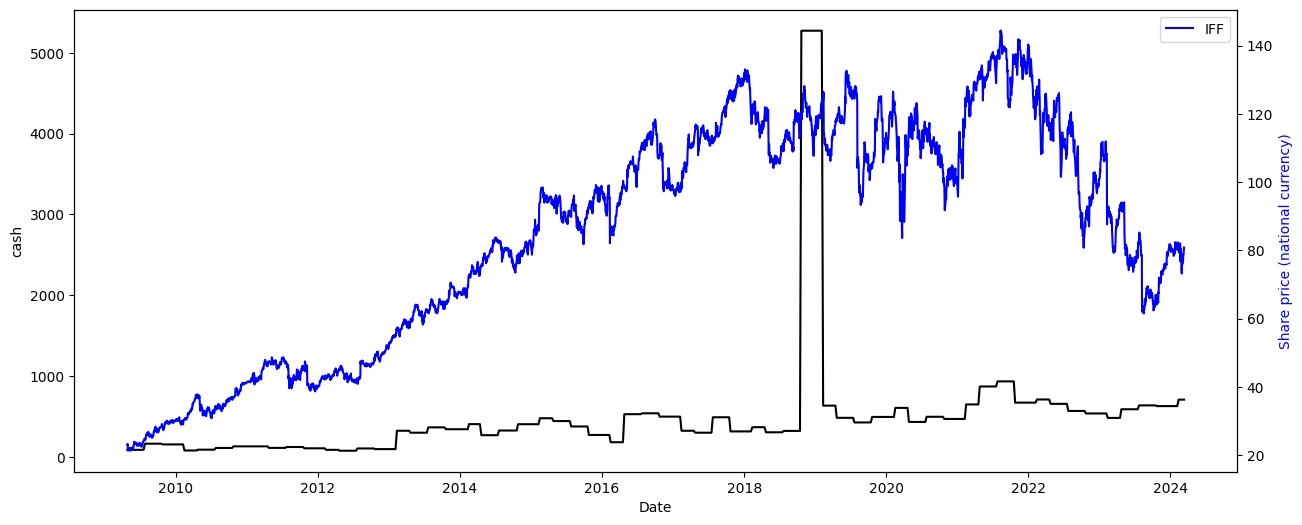

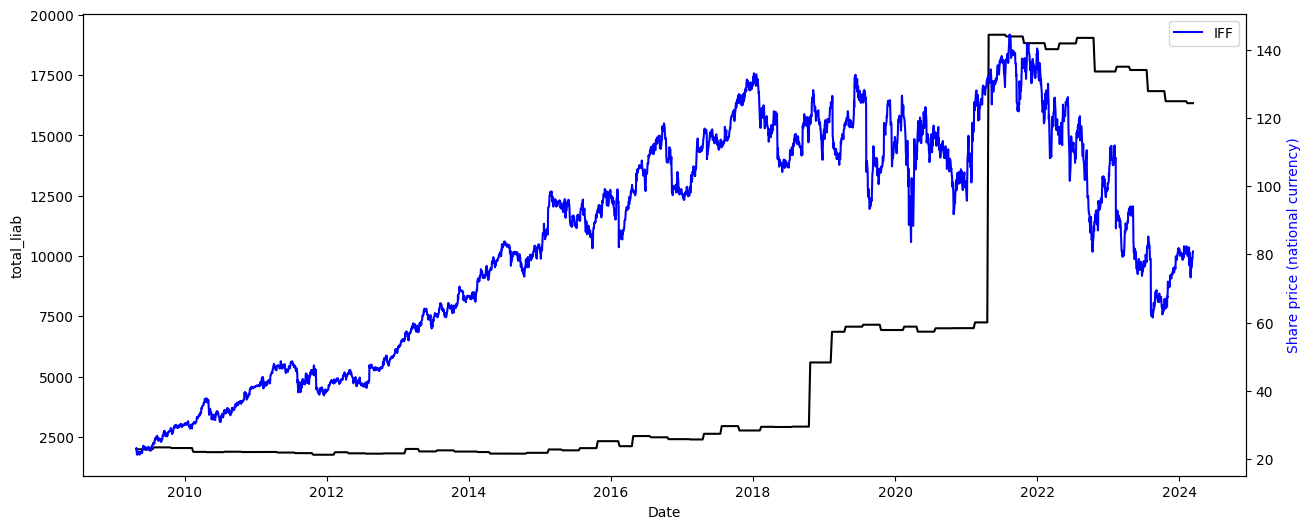

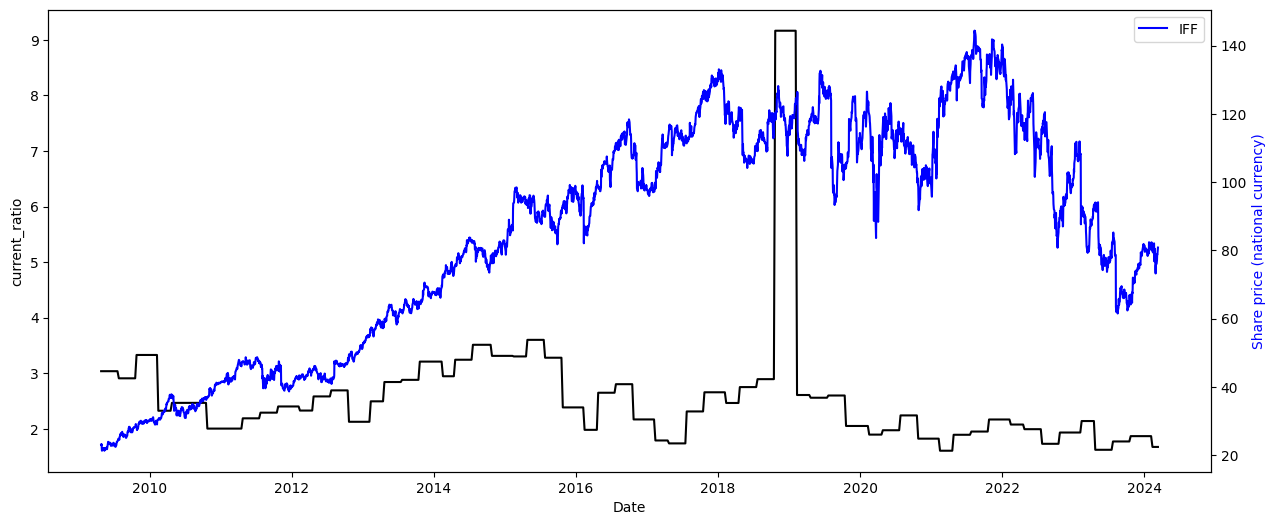

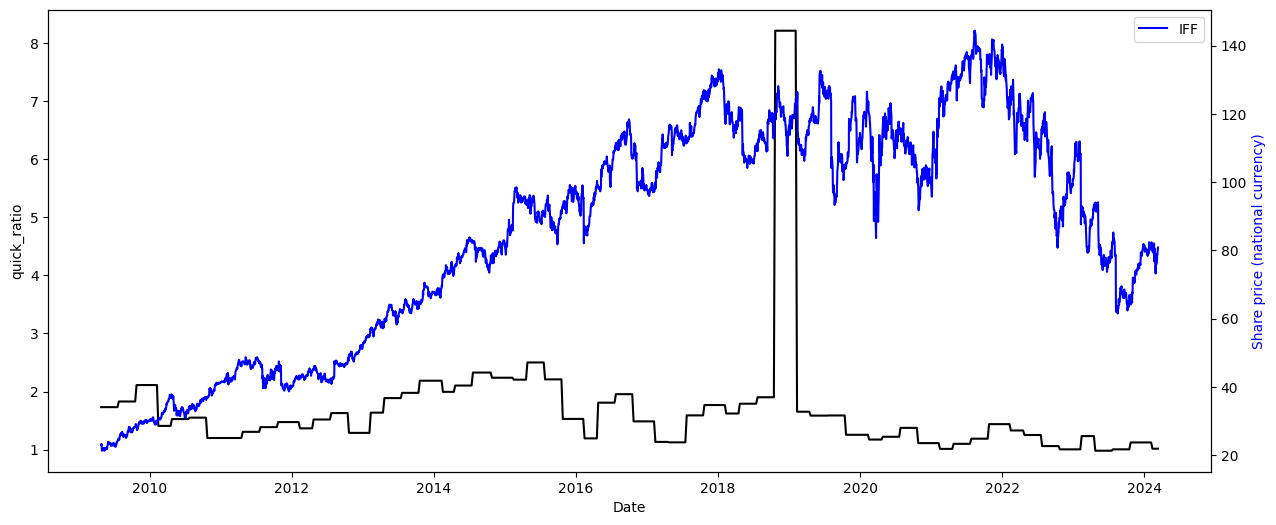

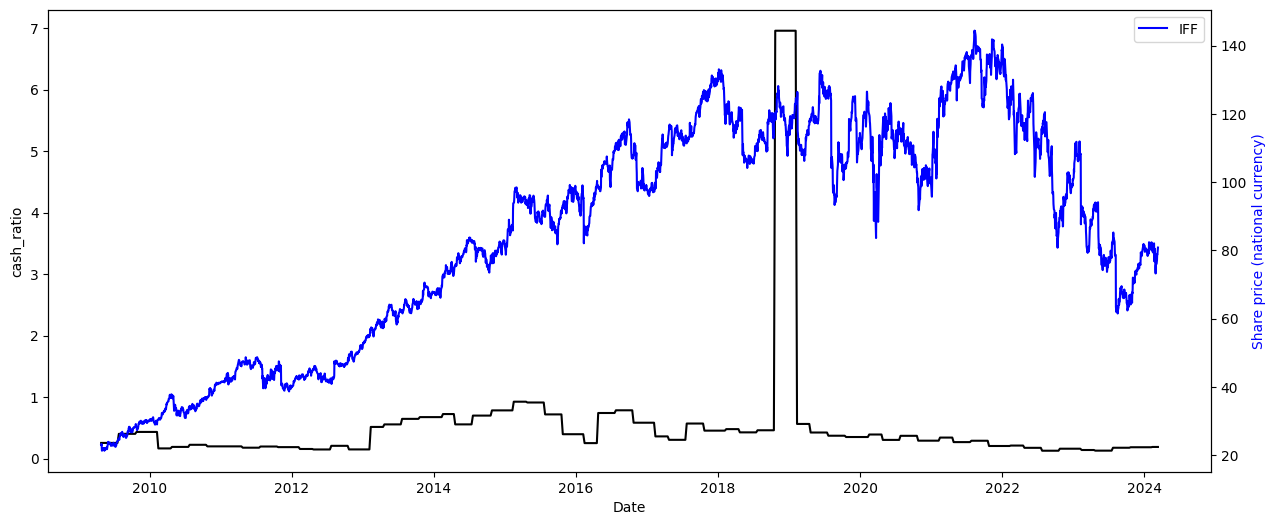

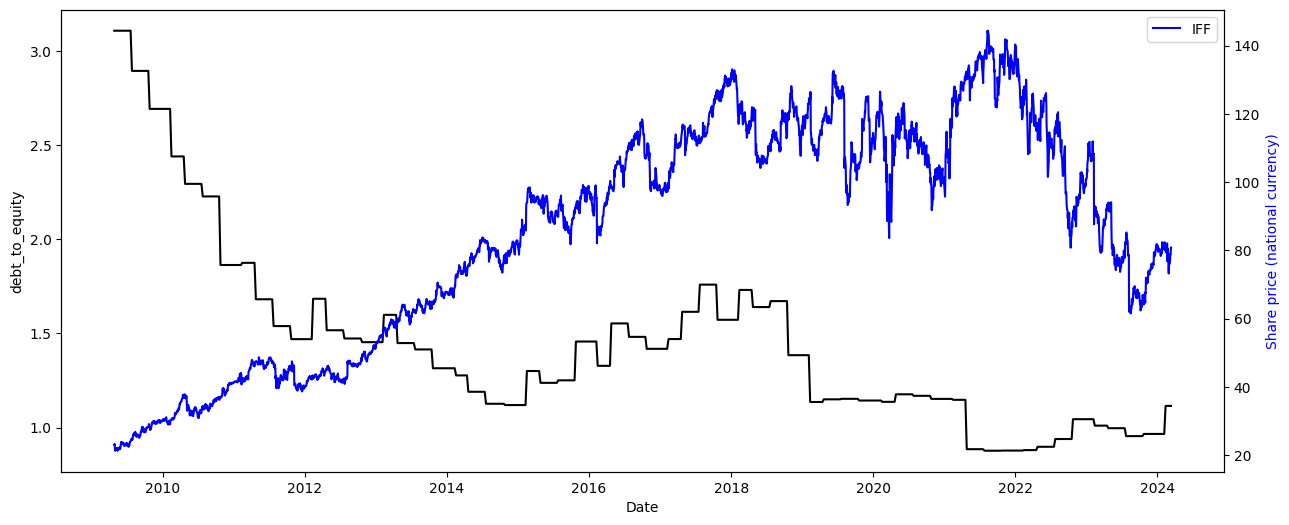

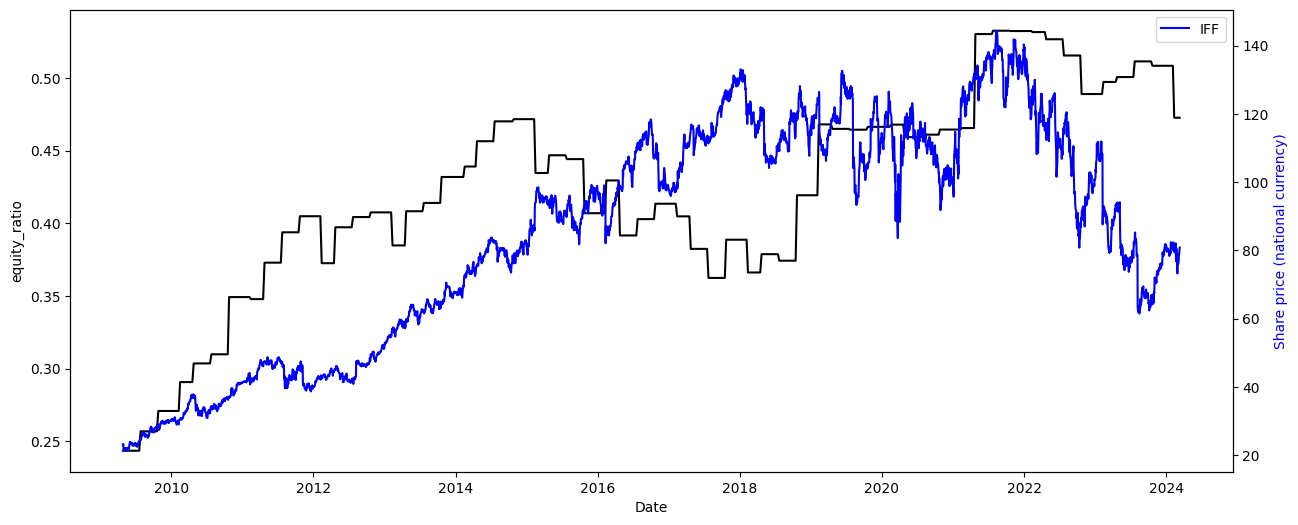

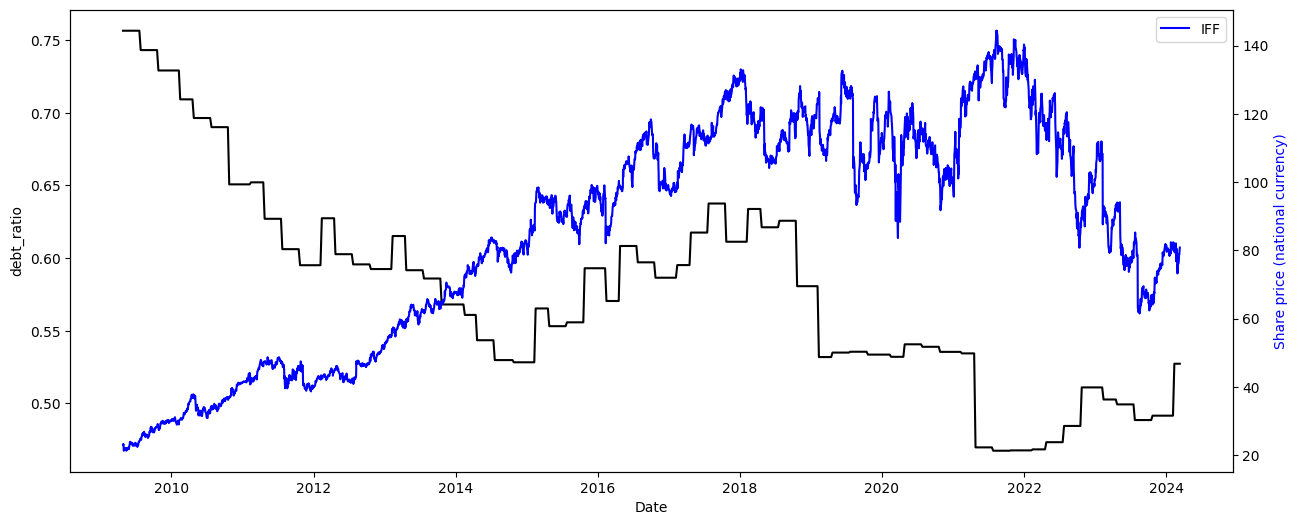

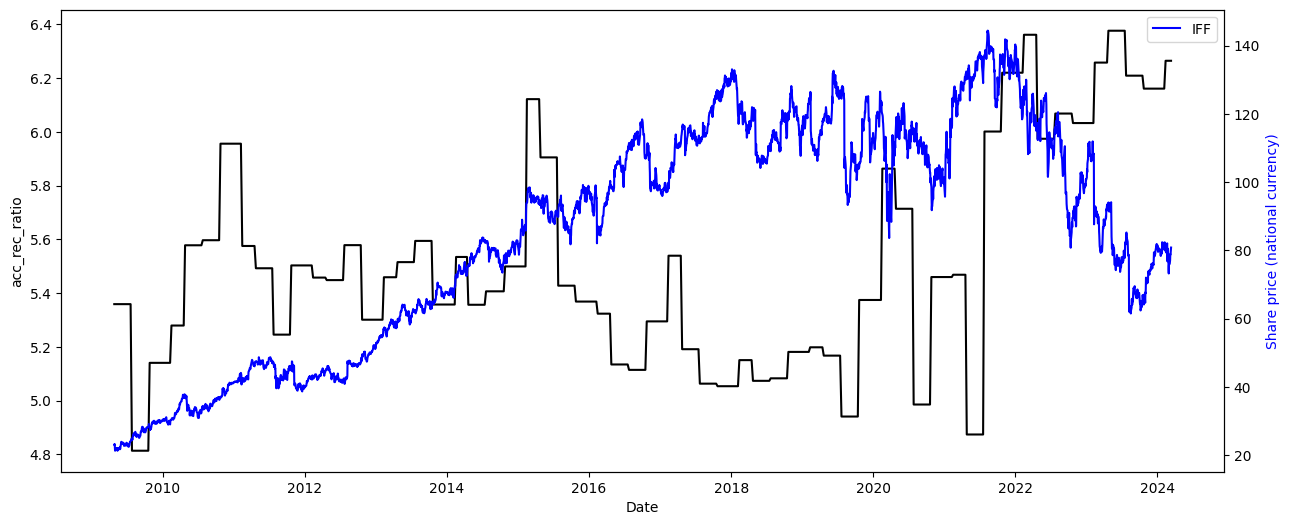

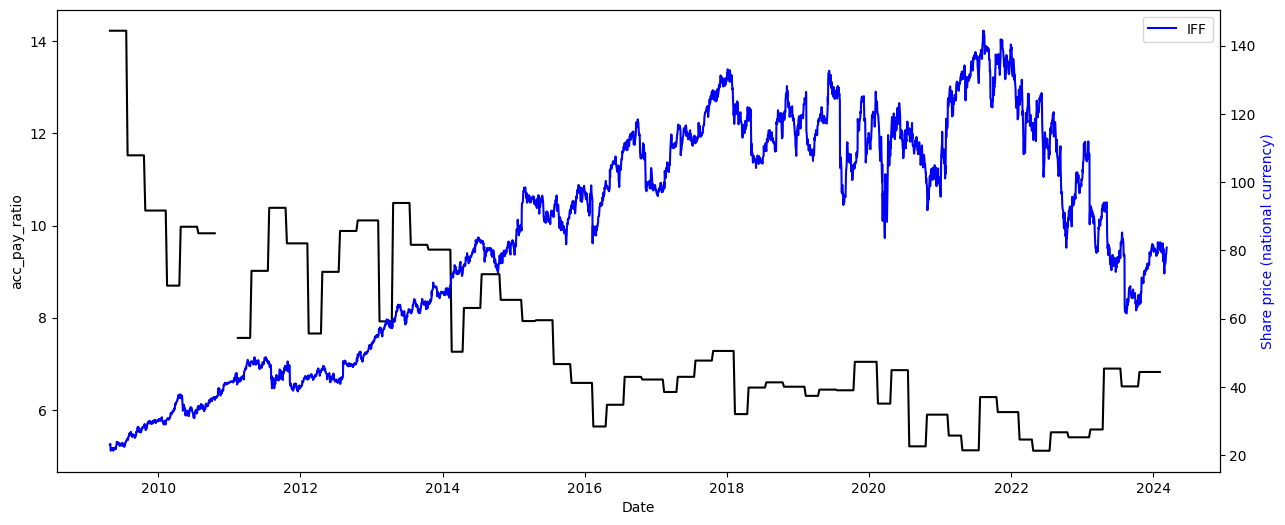

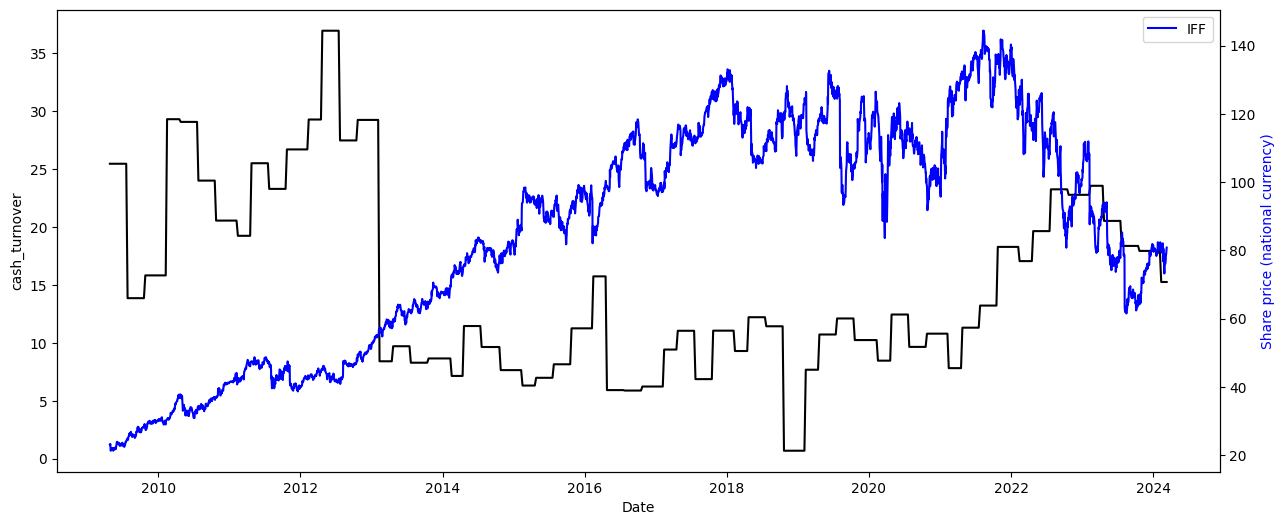

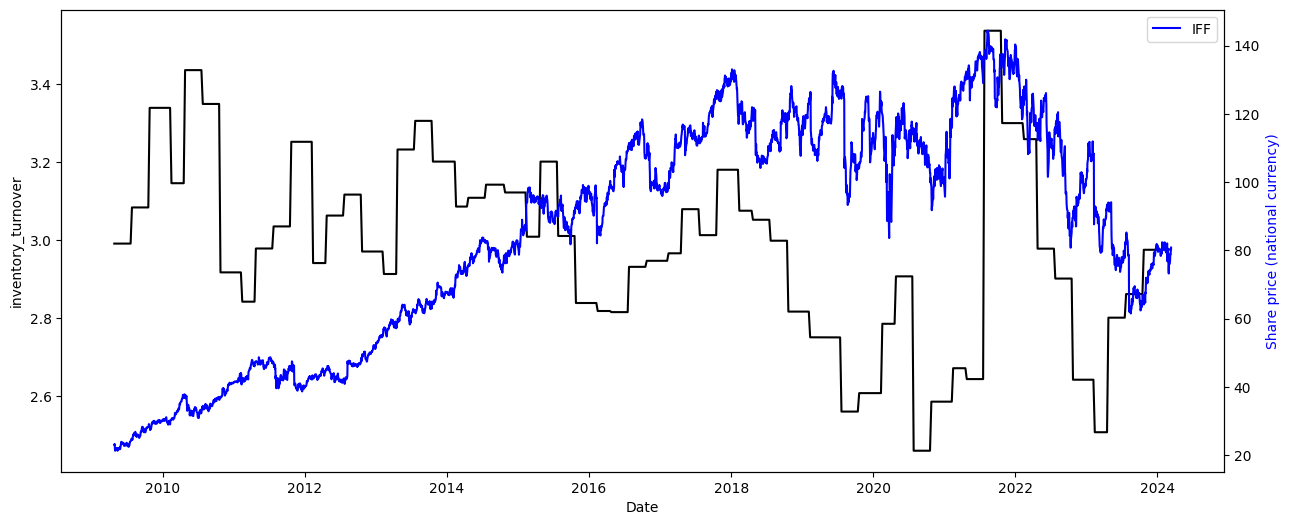

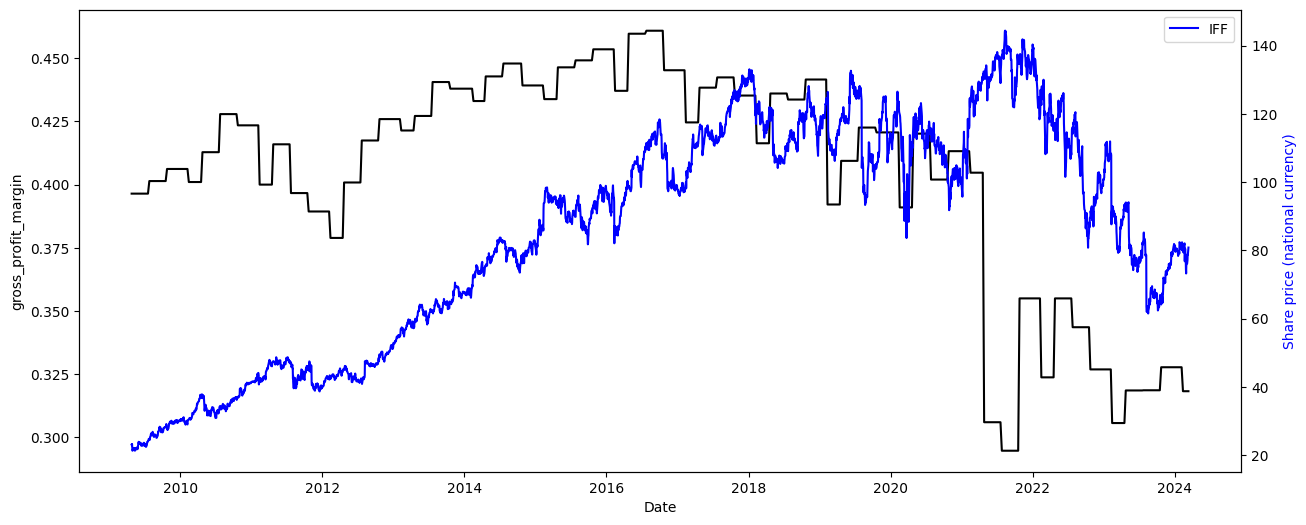

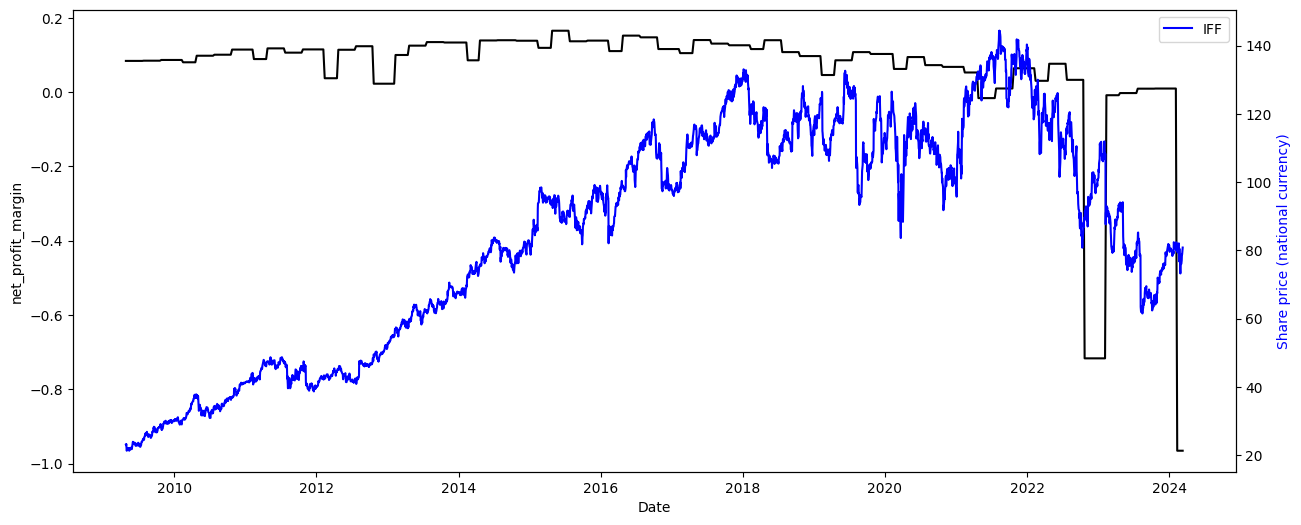

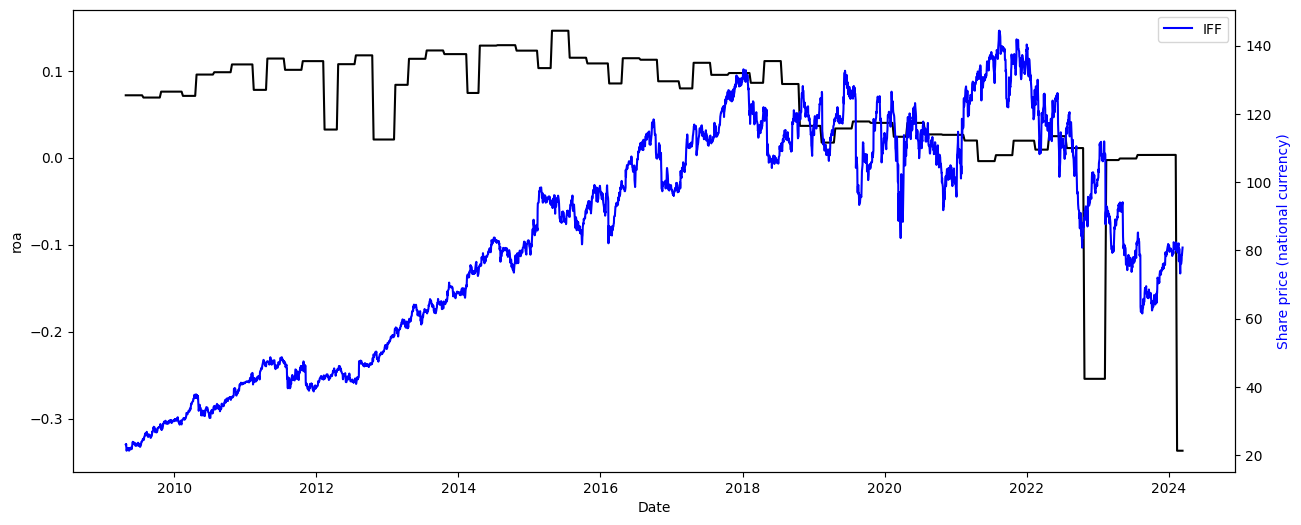

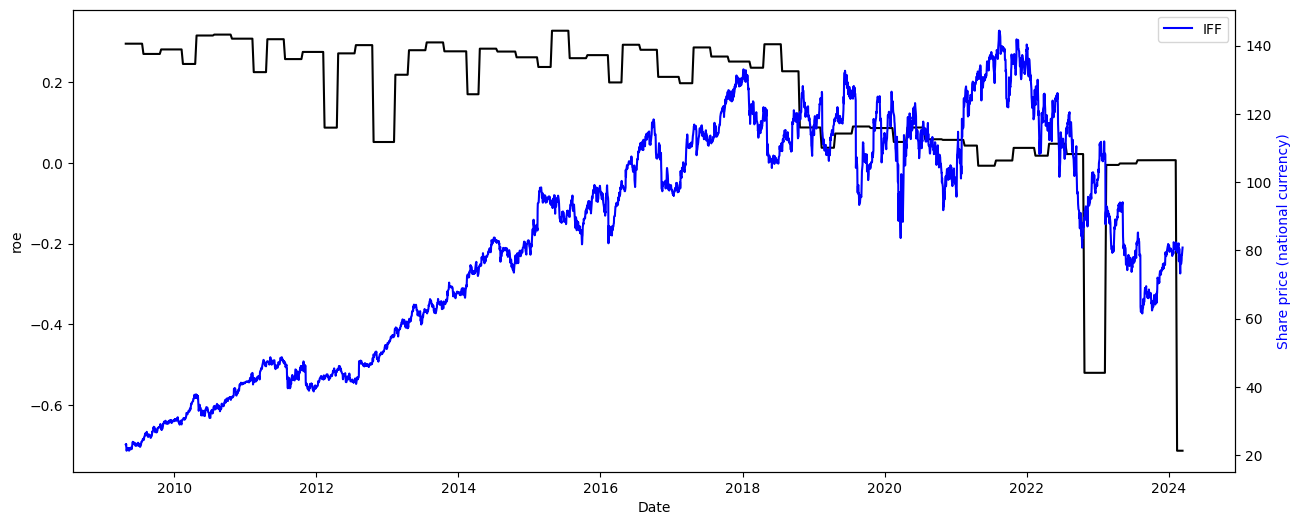

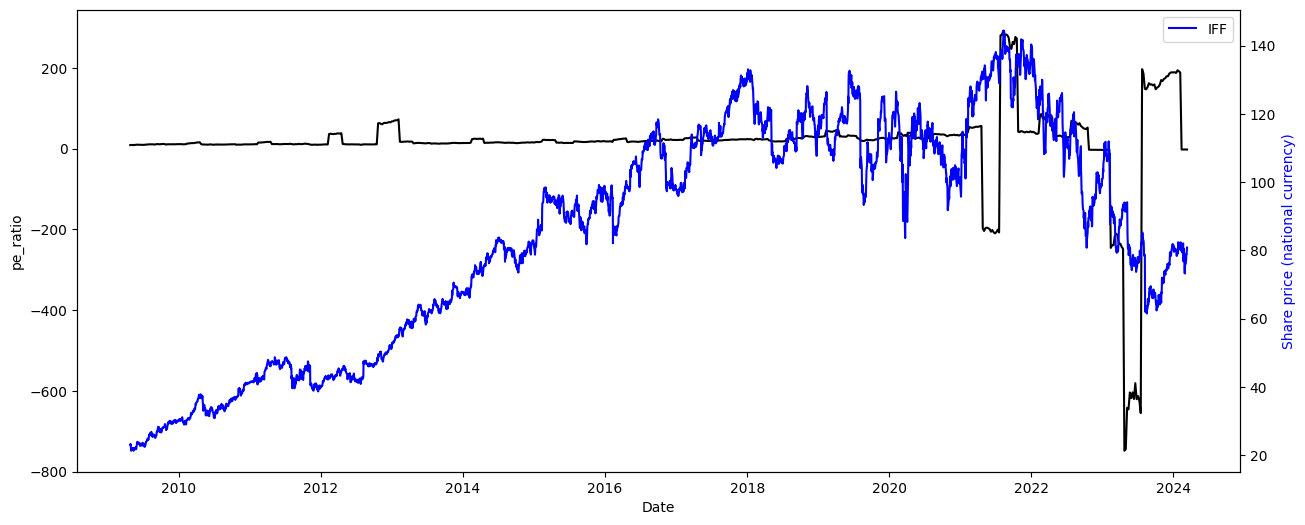

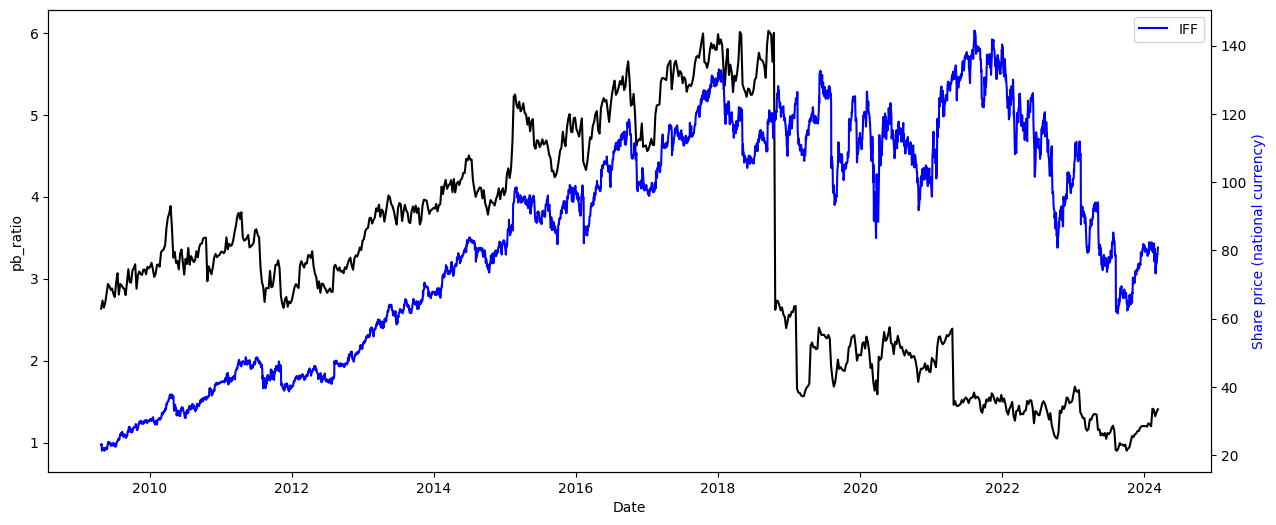

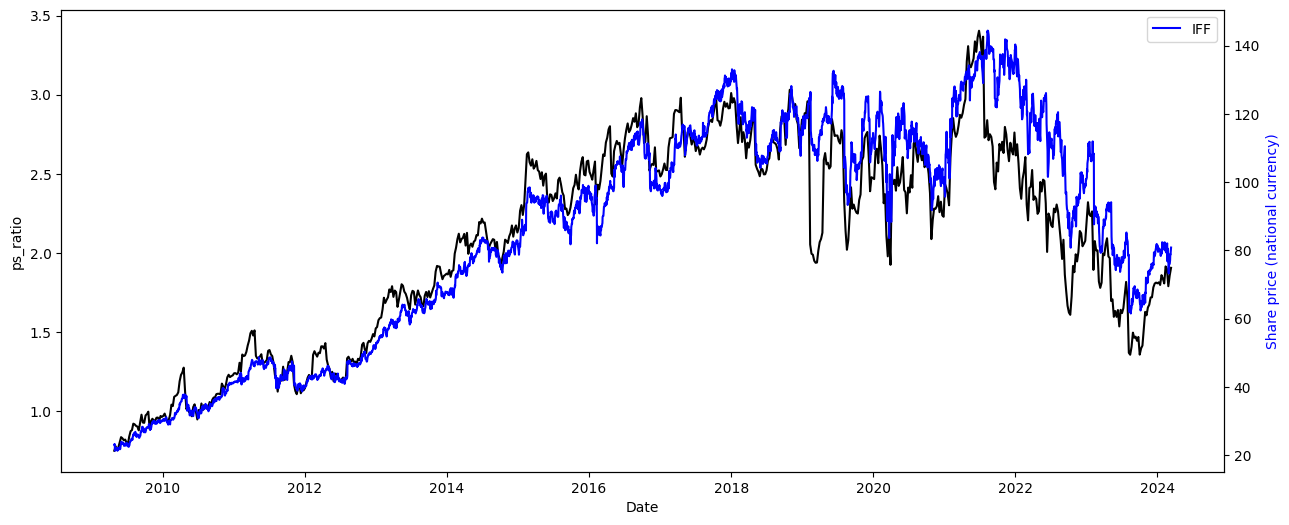

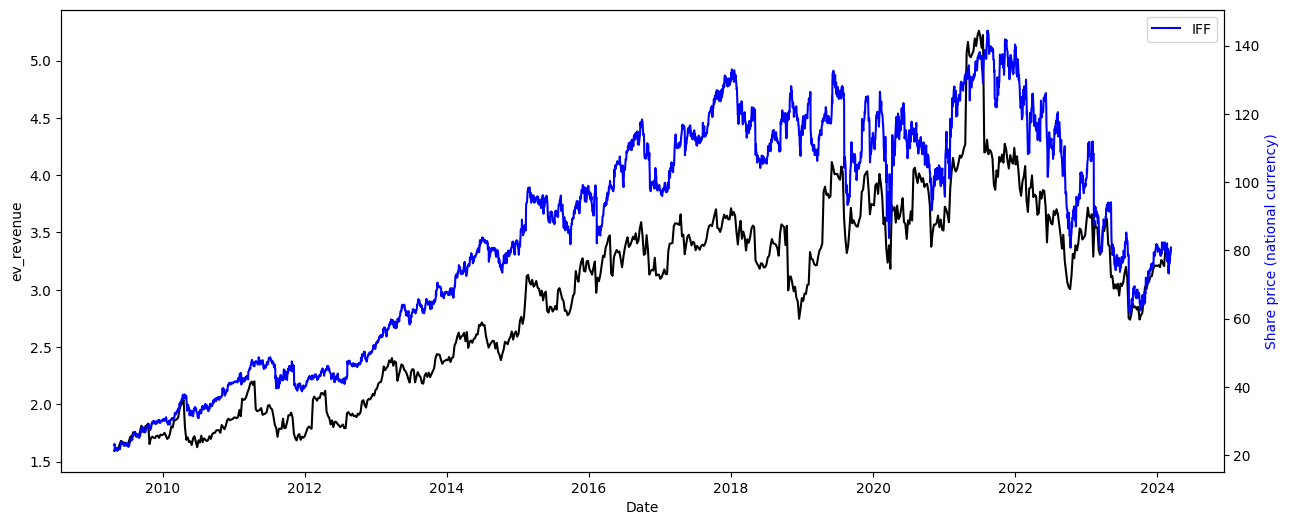

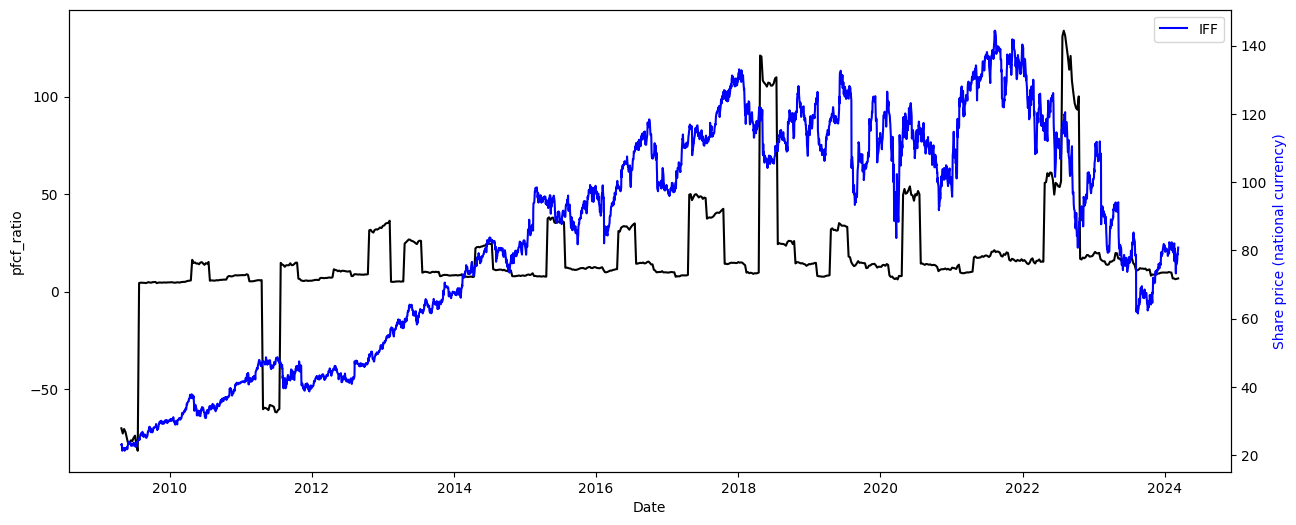

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

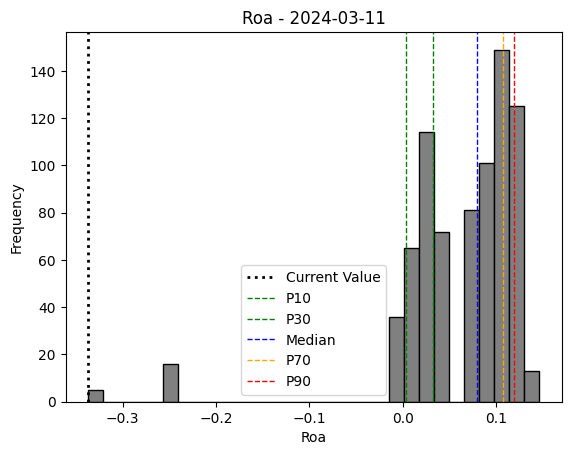

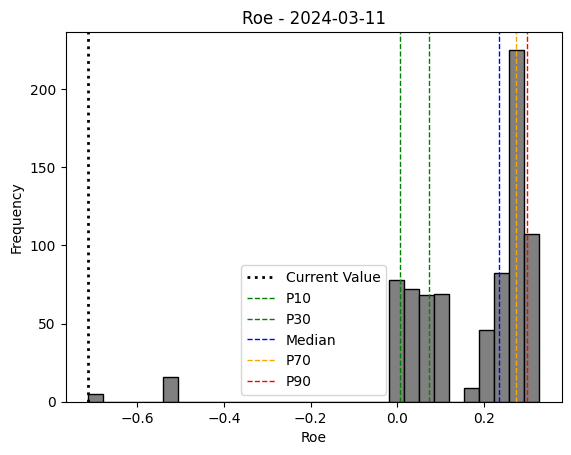

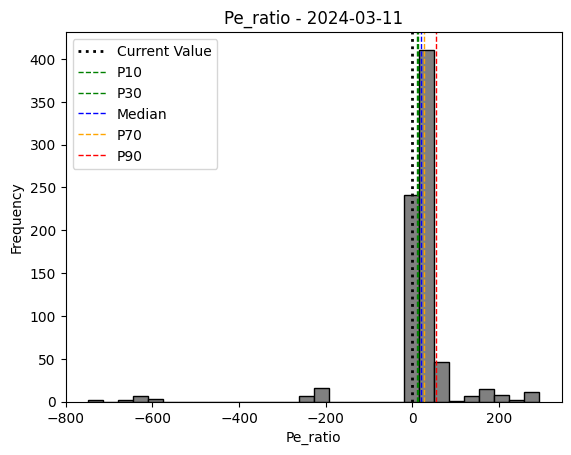

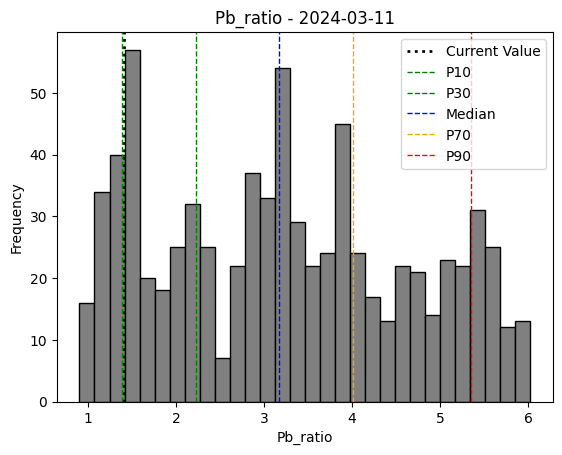

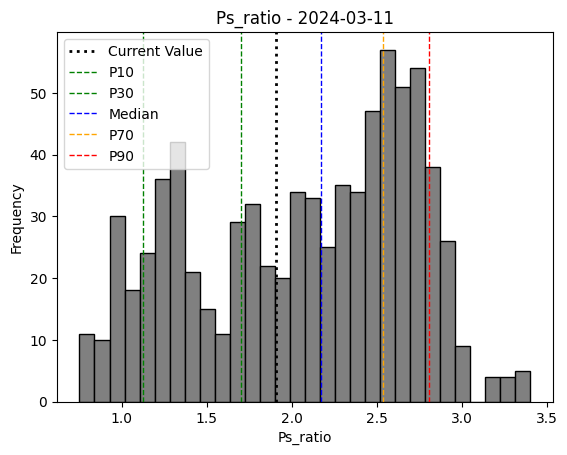

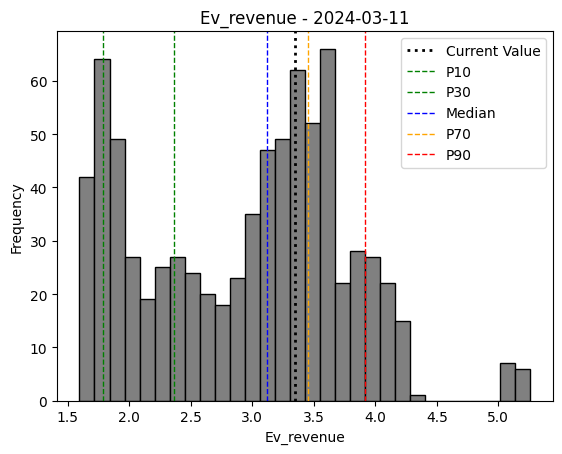

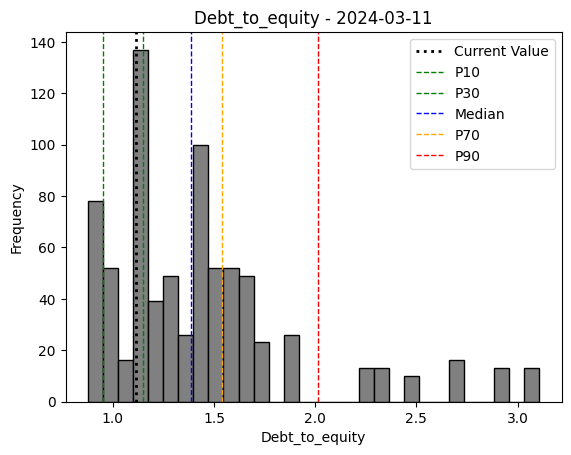

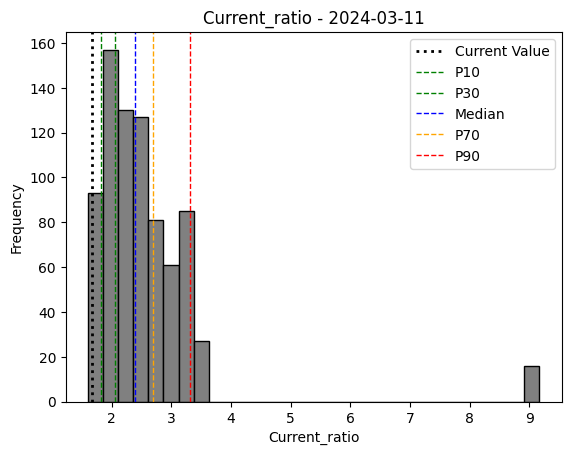

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.978406,0.059488,0.629864,-0.084419,-0.387806,0.329280,0.211752
roe,0.978406,1.000000,0.053860,0.650295,-0.198221,-0.490474,0.508775,0.204852
pe_ratio,0.059488,0.053860,1.000000,0.078452,0.042037,-0.019365,0.015538,0.053722
pb_ratio,0.629864,0.650295,0.078452,1.000000,0.235120,-0.175447,0.356478,0.177419
ps_ratio,-0.084419,-0.198221,0.042037,0.235120,1.000000,0.882071,-0.558364,0.102098
ev_revenue,-0.387806,-0.490474,-0.019365,-0.175447,0.882071,1.000000,-0.653885,-0.182916
debt_to_equity,0.329280,0.508775,0.015538,0.356478,-0.558364,-0.653885,1.000000,0.139059
current_ratio,0.211752,0.204852,0.053722,0.177419,0.102098,-0.182916,0.139059,1.000000


0 timestemos have been found!


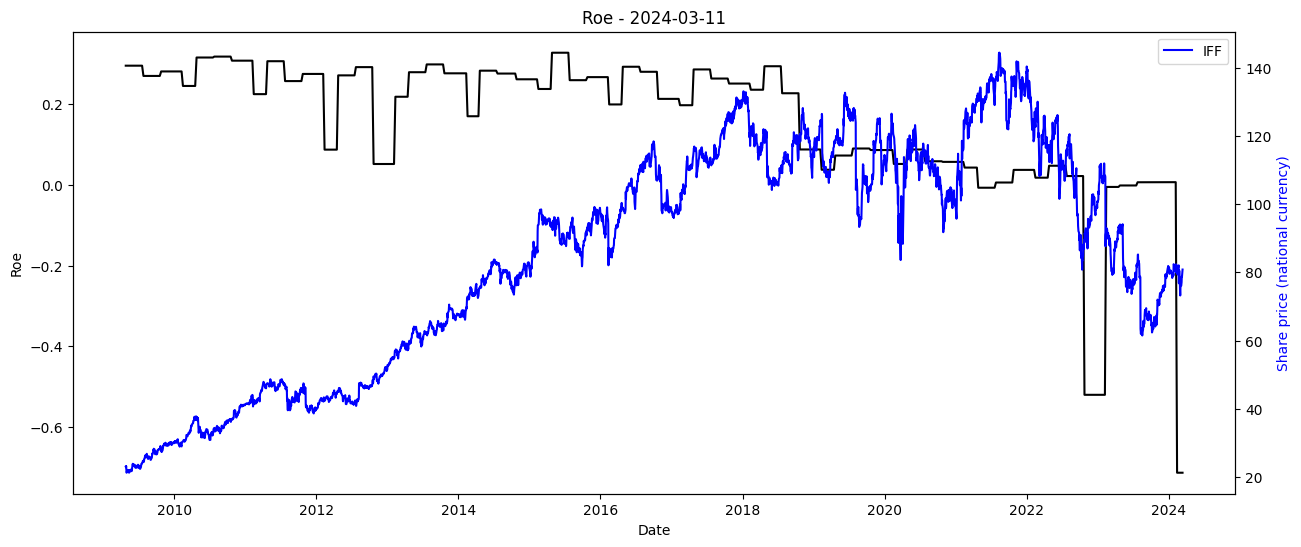

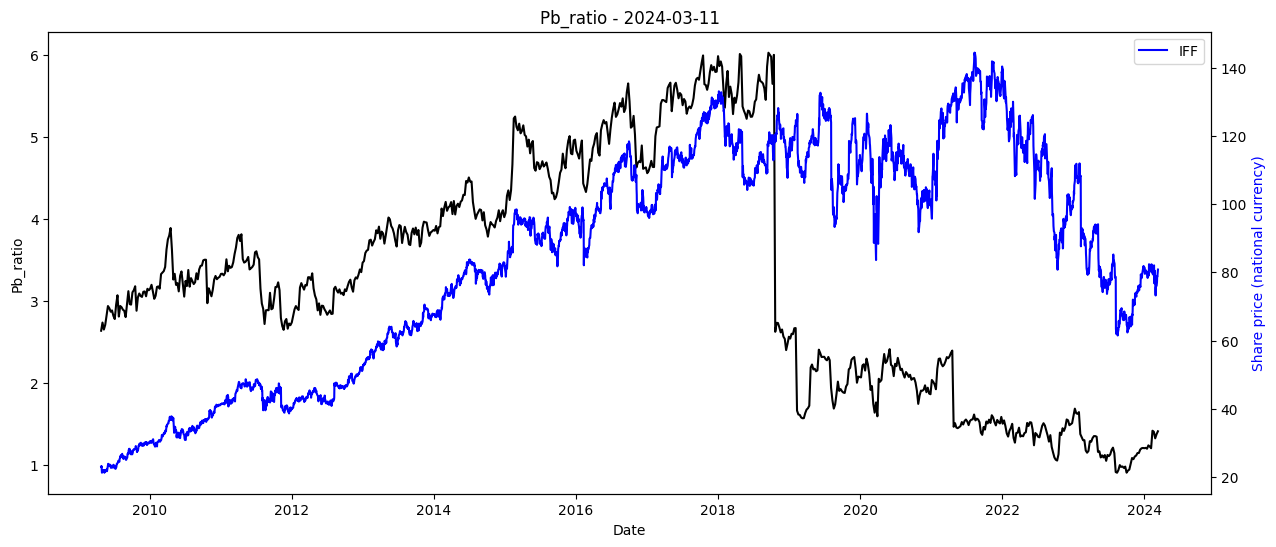

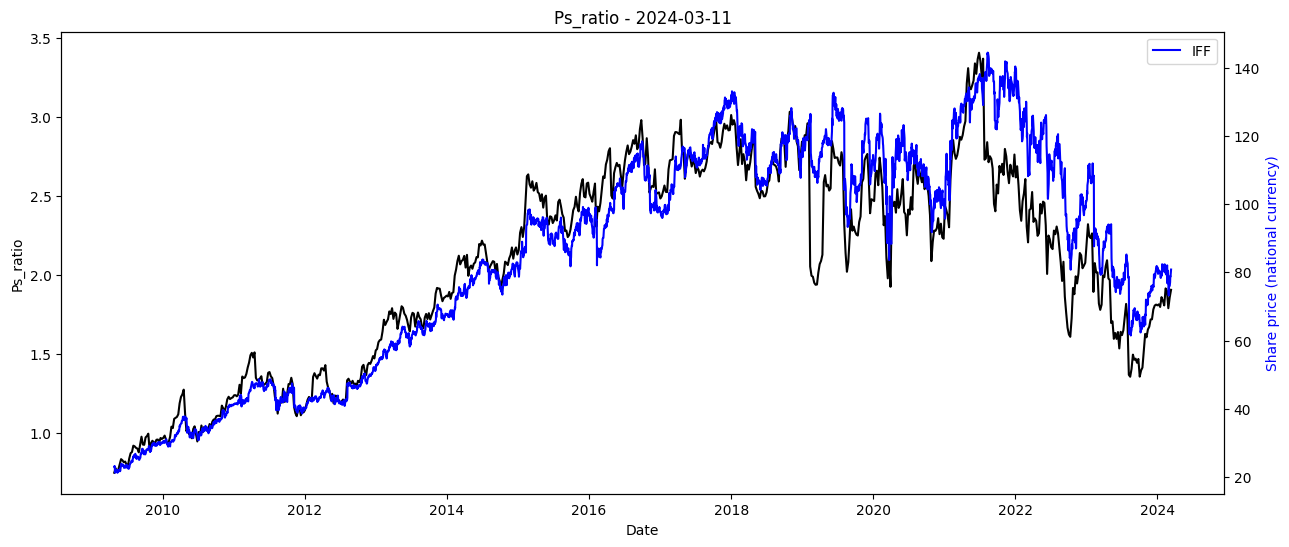

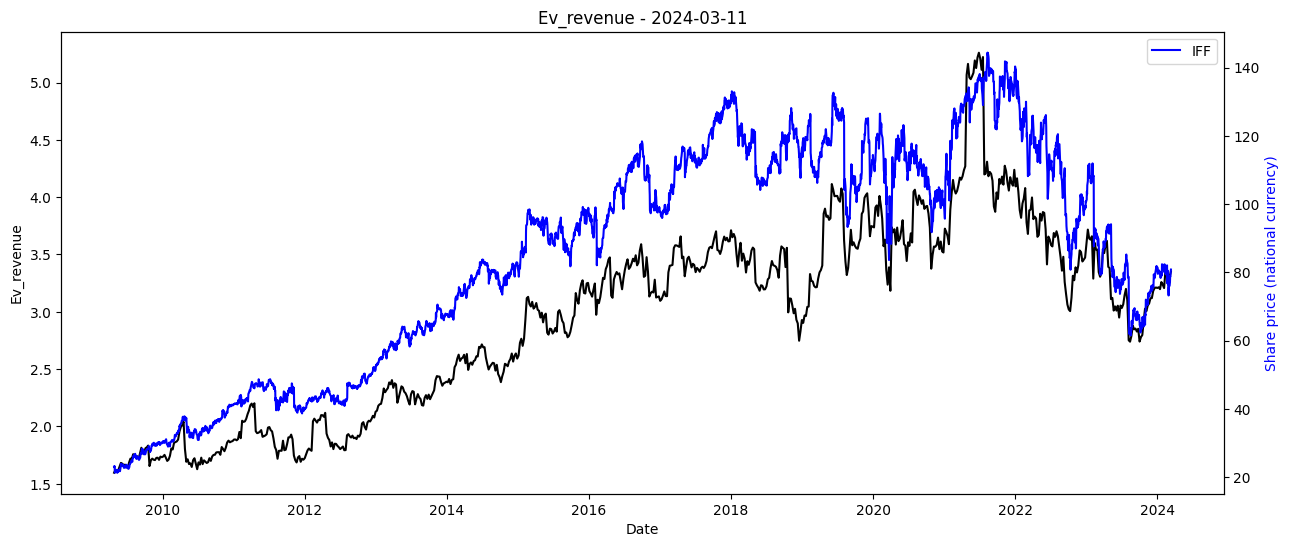

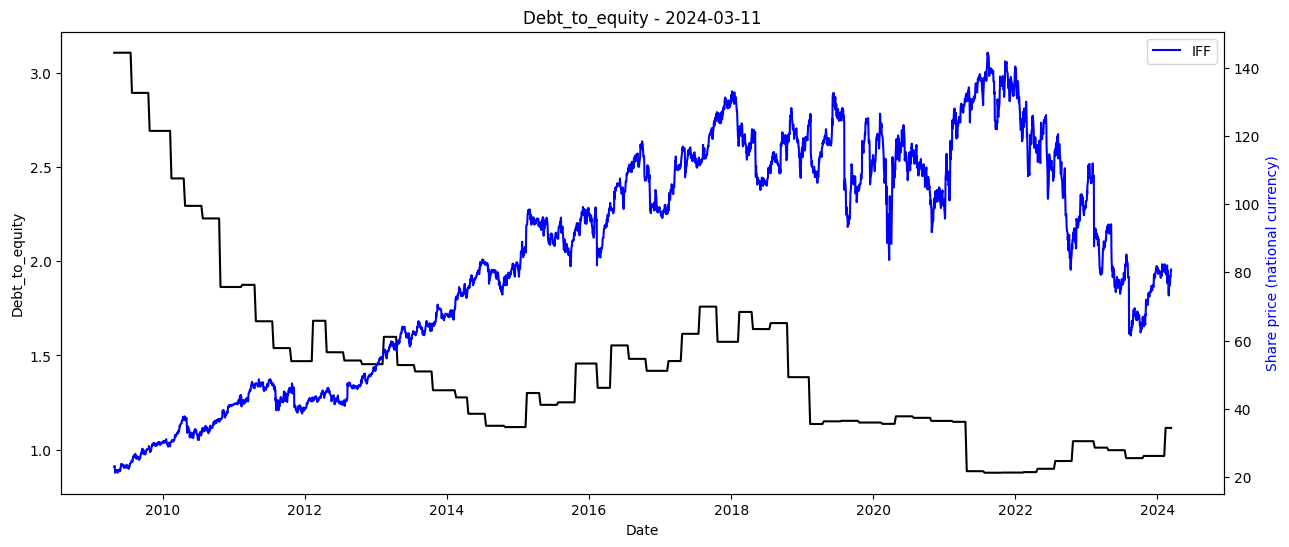

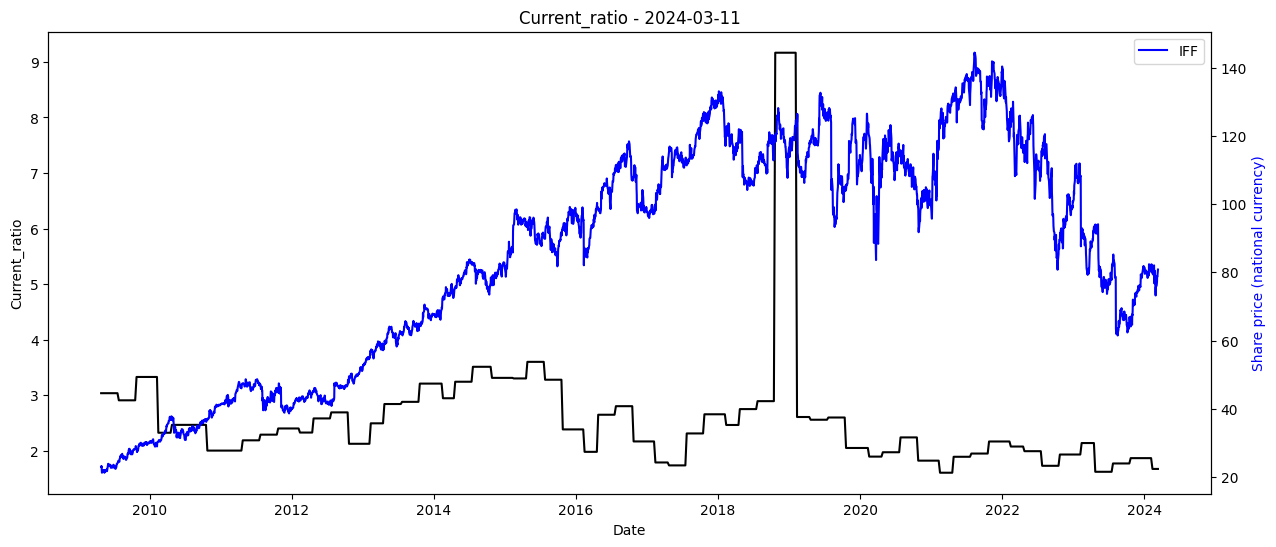

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )